In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold


import os,glob
from src.baseline import baseline_model, evalulate_model_accuracy, cramers_v
from src.baseline.preprocess_data import down_sampling, remove_outliers

In [2]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

<Axes: >

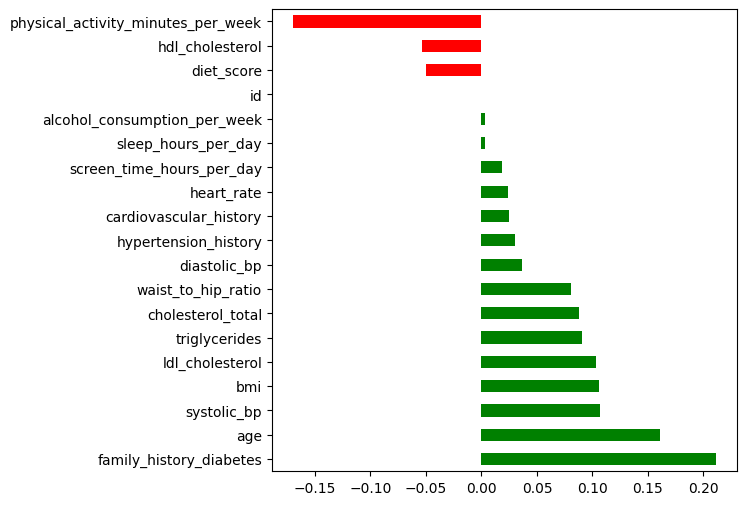

In [3]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

fig, ax = plt.subplots(figsize=(10, 10)) 
diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

In [4]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['ada_risk_factor_count'] = (
        (df['gender'] == 'Male').astype(int)
        + (df['age'] > 35).astype(int)
        + (df['bmi'] >= 25).astype(int)
        + (df['bmi'] >= 30).astype(int)
        + (df['bmi'] >= 35).astype(int)
        + (df['physical_activity_minutes_per_week'] < 100).astype(int)
        + (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80).astype(int)
        + (df['hdl_cholesterol'] < 35).astype(int)
        + (df['triglycerides'] > 150).astype(int)
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        )

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    df['toxic_lifestyle'] = (
        (df['diet_score'] < 5).astype(int) +
        (df['sleep_hours_per_day'] < 7).astype(int) +
        (df['screen_time_hours_per_day'] > 6).astype(int) +
        (df['alcohol_consumption_per_week'] > 7).astype(int) +
        (df['physical_activity_minutes_per_week'] < 100).astype(int)
    )
     
    df['age_bmi'] = df['age'] * df['bmi']

    df['age_family_history'] = df['age'] * df['family_history_diabetes']
    df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    
    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df
    
data_csv2 = clinical_features(data_csv)

['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'ada_risk_factor_count', 'bp_normal', 'toxic_lifestyle', 'age_bmi', 'age_family_history', 'bmi_family_history', 'age_bmi_family_history', 'cardio_comorbidity_count']


<Axes: >

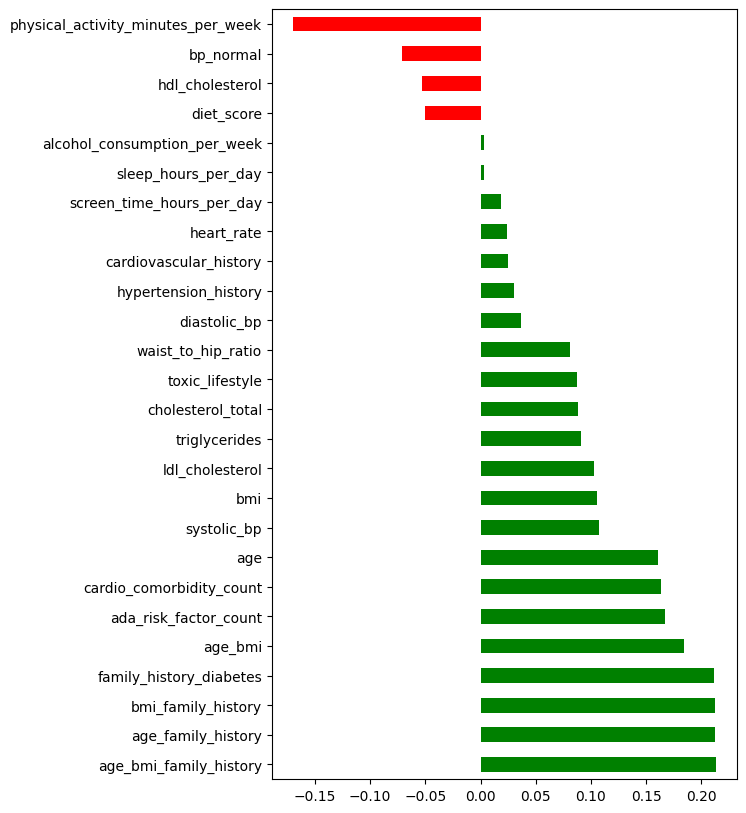

In [5]:
numerical_features = data_csv2.select_dtypes(include=[np.number]).columns.drop(['id']).tolist(); print(numerical_features)

corr_matrix = data_csv2[numerical_features].corr()
diab_corr   = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diab_corr]
diab_corr.plot(kind='barh', color=colors, figsize=(6, 10))

In [36]:
train_data , test_data = train_test_split(data_csv2, test_size=0.2, random_state=8964)

In [38]:
n_fold = 5 

stratified_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8964)
kfold = stratified_kfold.split(train_data, train_data['diagnosed_diabetes'])

numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'Fold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[train_idx]
    valid_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[valid_idx]

    train_target = train_data['diagnosed_diabetes'].iloc[train_idx]; print(train_target.value_counts()) 
    valid_target = train_data['diagnosed_diabetes'].iloc[valid_idx]; print(valid_target.value_counts())

    # train_value_counts = train_target.value_counts()
    # train_value_counts_ratio = train_value_counts[1] / train_value_counts.sum()

    # valid_value_counts = valid_target.value_counts()
    # valid_value_counts_ratio = valid_value_counts[1] / valid_value_counts.sum()

    # print(f'[train] diagonsed_diabetes positive ratio: {train_value_counts_ratio}')
    # print(f'[valid] diagonsed_diabetes positive ratio: {valid_value_counts_ratio}')

    log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)

    print('-' * 16)


Fold 1 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
diagnosed_diabetes
1.0    279184
0.0    168816
Name: count, dtype: int64
diagnosed_diabetes
1.0    69796
0.0    42204
Name: count, dtype: int64


/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6633125
RandomForestClassifier 0.6649642857142857
Accuracy:  LogisticRegression 0.6633125
ROC-AUC :  LogisticRegression 0.6955754568227346
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43     42204
         1.0       0.68      0.86      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.65      0.66      0.64    112000

Confusion Matrix:
[[13996 28208]
 [ 9501 60295]]
Accuracy:  RandomForestClassifier 0.6649642857142857
ROC-AUC :  RandomForestClassifier 0.6981627133743827
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42     42204
         1.0       0.68      0.87      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.65      0.66      0

/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6625446428571429
RandomForestClassifier 0.6645714285714286
Accuracy:  LogisticRegression 0.6625446428571429
ROC-AUC :  LogisticRegression 0.6919279248183526
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.33      0.43     42204
         1.0       0.68      0.86      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.65      0.66      0.64    112000

Confusion Matrix:
[[14077 28127]
 [ 9668 60128]]
Accuracy:  RandomForestClassifier 0.6645714285714286
ROC-AUC :  RandomForestClassifier 0.6955510124720051
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42     42204
         1.0       0.68      0.87      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.6

/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6643125
RandomForestClassifier 0.6679464285714286
Accuracy:  LogisticRegression 0.6643125
ROC-AUC :  LogisticRegression 0.6958867577764939
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.34      0.43     42204
         1.0       0.68      0.86      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.60    112000
weighted avg       0.65      0.66      0.64    112000

Confusion Matrix:
[[14209 27995]
 [ 9602 60194]]
Accuracy:  RandomForestClassifier 0.6679464285714286
ROC-AUC :  RandomForestClassifier 0.7001581925807215
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.34      0.43     42204
         1.0       0.68      0.87      0.77     69796

    accuracy                           0.67    112000
   macro avg       0.65      0.60      0.60    112000
weighted avg       0.66      0.67      0

/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6630892857142857
RandomForestClassifier 0.6639464285714286
Accuracy:  LogisticRegression 0.6630892857142857
ROC-AUC :  LogisticRegression 0.6940394305841655
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.33      0.43     42204
         1.0       0.68      0.86      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.65      0.66      0.64    112000

Confusion Matrix:
[[14017 28187]
 [ 9547 60249]]
Accuracy:  RandomForestClassifier 0.6639464285714286
ROC-AUC :  RandomForestClassifier 0.6975406770427033
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.32      0.42     42204
         1.0       0.68      0.87      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.6

/Users/k.choi/Documents/github/diabetes-diagonsis/stats_tools/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.6624285714285715
RandomForestClassifier 0.6640357142857143
Accuracy:  LogisticRegression 0.6624285714285715
ROC-AUC :  LogisticRegression 0.6941804969445624
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.33      0.42     42204
         1.0       0.68      0.86      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.65      0.66      0.63    112000

Confusion Matrix:
[[13819 28385]
 [ 9423 60373]]
Accuracy:  RandomForestClassifier 0.6640357142857143
ROC-AUC :  RandomForestClassifier 0.6974924968387095
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.32      0.42     42204
         1.0       0.68      0.87      0.76     69796

    accuracy                           0.66    112000
   macro avg       0.64      0.60      0.59    112000
weighted avg       0.6

In [ ]:
for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'Fold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_inputs = train_data.drop(columns=['diagnosed_diabetes']).iloc[train_idx]
    valid_inputs = train_data.drop(columns=['diagnosed_diabetes']).iloc[valid_idx]

    train_target = train_data['diagnosed_diabetes'].iloc[train_idx]; print(train_target.value_counts()) 
    valid_target = train_data['diagnosed_diabetes'].iloc[valid_idx]; print(valid_target.value_counts())

    train_value_counts = train_target.value_counts()
    train_value_counts_ratio = train_value_counts[1] / train_value_counts.sum()

    valid_value_counts = valid_target.value_counts()
    valid_value_counts_ratio = valid_value_counts[1] / valid_value_counts.sum()

    print(f'[train] diagonsed_diabetes positive ratio: {train_value_counts_ratio}')
    print(f'[valid] diagonsed_diabetes positive ratio: {valid_value_counts_ratio}')

    log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)

    print('-' * 16)

In [ ]:
for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'Fold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_inputs = train_data.drop(columns=['diagnosed_diabetes']).iloc[train_idx]
    valid_inputs = train_data.drop(columns=['diagnosed_diabetes']).iloc[valid_idx]

    train_target = train_data['diagnosed_diabetes'].iloc[train_idx]; print(train_target.value_counts()) 
    valid_target = train_data['diagnosed_diabetes'].iloc[valid_idx]; print(valid_target.value_counts())

    train_value_counts = train_target.value_counts()
    train_value_counts_ratio = train_value_counts[1] / train_value_counts.sum()

    valid_value_counts = valid_target.value_counts()
    valid_value_counts_ratio = valid_value_counts[1] / valid_value_counts.sum()

    print(f'[train] diagonsed_diabetes positive ratio: {train_value_counts_ratio}')
    print(f'[valid] diagonsed_diabetes positive ratio: {valid_value_counts_ratio}')

    log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)

    print('-' * 16)

In [ ]:

    train_inputs = inputs_data.iloc[train_idx]
    valid_inputs = inputs_data.iloc[valid_idx]

    train_target = targets_data.iloc[train_idx]; print(train_target.value_counts())
    valid_target = targets_data.iloc[valid_idx]; print(valid_target.value_counts())

    log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)